In [32]:
# Author: Mikita Sazanovich

# Problem by Daniel Kudenko:
# Create an abstraction of this domain in the form of an abstract MDP 
# (i.e. an MDP that only uses abstract states and actions). Then use the 
# value function computed on this abstract MDP to shape the reward of Q 
# learning on the full (i.e. detailed low-level) MDP, using 
# potential-based reward shaping. Compare the performance of this approach 
# with regular Q learning.

In [33]:
N = 13
M = 18
ROOM_DESC = [
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'FFFFFFEEEBBBBCCCCC',
    'FFFFFFEEEBBBBCCCCC',
    'FFFFFFGGGGGGGCCCCC',
    'FFFFFFGGGGGGGCCCCC',
    'FFFFFFGGGGGGGCCCCC',
    'FFFFFFGGGGGGGCCCCC',
]
INTER_CONS = {
    ((3, 4), (4, 4)), ((4, 4), (3, 4)),
    ((5, 5), (5, 6)), ((5, 6), (5, 5)),
    ((5, 8), (5, 9)), ((5, 9), (5, 8)),
    ((6, 1), (7, 1)), ((7, 1), (6, 1)),
    ((8, 7), (9, 7)), ((9, 7), (8, 7)),
    ((11, 12), (11, 13)), ((11, 13), (11, 12)),
}
COWS = [(0, 5), (8, 3), (2, 7), (3, 15), (12, 17), (10, 11)]
START = (5, 4)
GOAL = (11, 1)

REWARD_PER_COW = 100


def verify_environment():
    assert len(ROOM_DESC) == N
    for row in ROOM_DESC:
        assert len(row) == M
    assert len(COWS) == 6
    for ((x1, y1), (x2, y2)) in INTER_CONS:
        assert ROOM_DESC[x1][y1] != ROOM_DESC[x2][y2]


verify_environment()

In [34]:
class Action:
    def __init__(self, to_state, reward):
        self.to_state = to_state
        self.reward = reward

    def execute(self):
        return self.to_state, self.reward

    def __str__(self):
        return str(self.to_state) + " " + str(self.reward)


class State:
    def __init__(self, x, y, cow_mask):
        self.x = x
        self.y = y
        self.cow_mask = cow_mask
        self.actions = []

    def is_terminal(self):
        return (self.x, self.y) == GOAL

    def add_action(self, action):
        self.actions.append(action)

    def __eq__(self, other):
        if isinstance(other, State):
            return (self.x == other.x
                    and self.y == other.y
                    and self.cow_mask == other.cow_mask)
        else:
            return False

    def __hash__(self):
        return hash((self.x, self.y, self.cow_mask))

    def __str__(self):
        return str(self.x) + " " + str(self.y) + " " + str(self.cow_mask)


def build_states():
    def is_valid_cell(x, y):
        return 0 <= x < N and 0 <= y < M

    def is_move_allowed(x1, y1, x2, y2):
        if ROOM_DESC[x1][y1] == ROOM_DESC[x2][y2]:
            return True
        if ((x1, y1), (x2, y2)) in INTER_CONS:
            return True
        return False

    dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    S = []
    S_index = {}
    max_mask = 1 << len(COWS)
    for x in range(N):
        for y in range(M):
            for mask in range(max_mask):
                state = State(x, y, mask)
                S_index[state] = len(S)
                S.append(state)
    for s in S:
        if s.is_terminal():
            s.add_action(Action(s, 0))
            continue
        x1, y1, mask1 = s.x, s.y, s.cow_mask
        if (x1, y1) in COWS:
            cow_index = COWS.index((x1, y1))
            mask2 = mask1 | (1 << cow_index)
            to_state = S[S_index[State(x1, y1, mask2)]]
            s.add_action(Action(to_state, 0))
        for drt in dirs:
            x2 = x1 + drt[0]
            y2 = y1 + drt[1]
            if is_valid_cell(x2, y2) and is_move_allowed(x1, y1, x2, y2):
                to_state = S[S_index[State(x2, y2, mask1)]]
                if to_state.is_terminal():
                    reward = REWARD_PER_COW * bin(mask1).count('1')
                else:
                    reward = 0
                s.add_action(Action(to_state, reward))
    return S

In [35]:
ABSTR_DESC = [
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'AAAAAABBBBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'DDDDDDEEEBBBBCCCCC',
    'FFFFFFEEEBBBBCCCCC',
    'FFFFFFEEEBBBBCCCCC',
    'FFFFFFGGGGGGGCCCCC',
    'FFFFFFGGGGGGGCCCCC',
    'FHFFFFGGGGGGGCCCCC',
    'FFFFFFGGGGGGGCCCCC',
]
ABSTR_MOVES = {
    'A': ['D'],
    'B': ['E'],
    'C': ['G'],
    'D': ['A', 'E', 'F'],
    'E': ['D', 'B', 'G'],
    'F': ['H', 'D'],
    'G': ['E', 'C'],
    'H': ['F'],
}
ABSTR_COWS = ['A', 'F', 'B', 'C', 'C', 'G']
ABSTR_START = 'D'
ABSTR_GOAL = 'H'


def verify_abstract_environment():
    assert len(ABSTR_DESC) == N
    for row in ABSTR_DESC:
        assert len(row) == M
    assert ABSTR_DESC[START[0]][START[1]] == ABSTR_START
    assert ABSTR_DESC[GOAL[0]][GOAL[1]] == ABSTR_GOAL
    assert len(ABSTR_COWS) == len(COWS)
    for index in range(len(COWS)):
        pos = COWS[index]
        assert ABSTR_DESC[pos[0]][pos[1]] == ABSTR_COWS[index]
        

verify_abstract_environment()

In [36]:
class AbstractState:
    def __init__(self, letter, cow_mask):
        self.letter = letter
        self.cow_mask = cow_mask
        self.actions = []

    def add_action(self, action):
        self.actions.append(action)

    def is_terminal(self):
        return self.letter == ABSTR_GOAL

    def __eq__(self, other):
        if isinstance(other, AbstractState):
            return (self.letter == other.letter
                    and self.cow_mask == other.cow_mask)
        else:
            return False

    def __hash__(self):
        return hash((self.letter, self.cow_mask))

    def __str__(self):
        return str(self.letter) + " " + str(self.cow_mask)


def build_abstract_states():
    S = []
    max_mask = 1 << len(ABSTR_COWS)
    for (letter, _) in ABSTR_MOVES.items():
        for mask in range(max_mask):
            S.append(AbstractState(letter, mask))
    for s in S:
        if s.is_terminal():
            s.add_action(Action(s, 0))
            continue
        letter = s.letter
        indexes = []
        for cow_index in range(len(ABSTR_COWS)):
            if ABSTR_COWS[cow_index] == letter:
                indexes.append(cow_index)
        for cow_index in indexes:
            new_mask = s.cow_mask | (1 << cow_index)
            to_state = S[S.index(AbstractState(letter, new_mask))]
            s.add_action(Action(to_state, 0))
        for to_letter in ABSTR_MOVES[s.letter]:
            to_state = S[S.index(AbstractState(to_letter, s.cow_mask))]
            if to_state.is_terminal():
                reward = REWARD_PER_COW * bin(s.cow_mask).count('1')
            else:
                reward = 0
            s.add_action(Action(to_state, reward))
    return S

In [66]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

training_episodes = 500
episode_steps_limit = 5000

seeds_to_test = 3


def plot_method_performance(method, method_name, S, color_iter):
    print(f'Plotting performance of {method_name}')
    learning_started = time()
    perf = np.zeros((seeds_to_test, training_episodes), dtype=float)
    for seed in range(seeds_to_test):
        global random
        random = np.random.RandomState(seed)
        seed_perf = method(S)
        perf[seed] = seed_perf
    means = []
    ses = []
    for episode in range(0, training_episodes, 10):
        rewards = perf[:, episode]
        mean = np.mean(rewards)
        se = np.std(rewards) / np.sqrt(seeds_to_test)
        means.append(mean)
        ses.append(se)
    print(f'Evaluating {method_name} with {seeds_to_test} seeds took',
          time() - learning_started, 'secs')
    line = plt.errorbar(range(0, training_episodes, 10), means, ses,
                        label=method_name, c=next(color_iter),
                        linestyle='-', marker='1')
    return line

In [67]:
eps_greedy = 0.3


def find_best_aindex_quality(Q, state):
    best_aindex, best_q = None, None
    for aindex in range(len(state.actions)):
        cur_q = Q[(state, aindex)]
        if best_q is None or best_q < cur_q:
            best_aindex, best_q = aindex, cur_q
    return best_aindex, best_q


def choose_aindex_following_eps_greedy(Q, state):
    best_aindex, best_q = find_best_aindex_quality(Q, state)
    is_best = []
    best_count = 0
    for aindex in range(len(state.actions)):
        if Q[(state, aindex)] == best_q:
            best_count += 1
            is_best.append(True)
        else:
            is_best.append(False)
    p = []
    for aindex in range(len(state.actions)):
        if is_best[aindex]:
            p.append((1 - eps_greedy) / best_count + eps_greedy / len(state.actions))
        else:
            p.append(eps_greedy / len(state.actions))
    aindex = random.choice(len(state.actions), 1, p=p)[0]
    return aindex

In [68]:
from collections import defaultdict

gamma = 0.99
potentials_weight = REWARD_PER_COW * len(COWS) / 14976


def get_start_state_index(S):
    return S.index(State(START[0], START[1], 0))


def to_abstract_state(state):
    return AbstractState(ABSTR_DESC[state.x][state.y], state.cow_mask)


def train_by_q_learning(S, V, alpha=0.1):
    Q = defaultdict(lambda: 0)
    perf = []
    start_index = get_start_state_index(S)
    for episode in range(training_episodes):
        state = S[start_index]
        step = 0
        reward = 0
        while not state.is_terminal() and step < episode_steps_limit:
            aindex = choose_aindex_following_eps_greedy(Q, state)
            action = state.actions[aindex]
            to_state, reward = action.execute()
            abs_state = to_abstract_state(state)
            to_abs_state = to_abstract_state(to_state)
            potential_delta = gamma * V[to_abs_state] - V[abs_state]
            _, best_to_q = find_best_aindex_quality(Q, to_state)
            q_diff = (reward + potentials_weight * potential_delta +
                      gamma * best_to_q - Q[(state, aindex)])
            Q[(state, aindex)] += alpha / (episode + 1) * q_diff
            state = to_state
            step += 1
        perf.append(reward)
    return perf

In [69]:
def compute_abstract_v():
    S = build_abstract_states()
    print('abstract states:', len(S))
    print('abstract actions:', sum(map(lambda state: len(state.actions), S)))
    V = defaultdict(lambda: 0)
    while True:
        max_diff = 0
        for s in S:
            max_v = 0.0
            for action in s.actions:
                to_state, reward = action.execute()
                max_v = max(max_v, reward + gamma * V[to_state])
            max_diff = max(max_diff, max_v - V[s])
            V[s] = max_v
        if max_diff == 0:
            break
    return V

states: 14976
actions: 50112
abstract states: 512
abstract actions: 1280


Plotting performance of Q-learning
Evaluating Q-learning with 3 seeds took 19.882516145706177 secs
Plotting performance of Q-learning with RS


Evaluating Q-learning with RS with 3 seeds took 124.86372423171997 secs


Text(0,0.5,'Reward per episode mean')

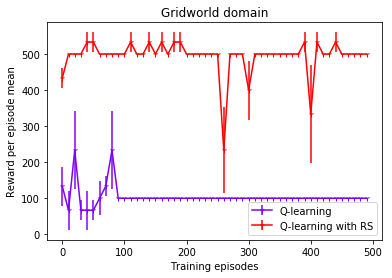

In [70]:
S = build_states()
print('states:', len(S))
print('actions:', sum(map(lambda state: len(state.actions), S)))

V = compute_abstract_v()

color = iter(plt.cm.rainbow(np.linspace(0, 1, 2)))

handles = [
    plot_method_performance(
        lambda S: train_by_q_learning(S, defaultdict(lambda: 0)),
        'Q-learning',
        S,
        color),
    plot_method_performance(
        lambda S: train_by_q_learning(S, V),
        'Q-learning with RS',
        S,
        color),
]
plt.legend(handles=handles)
plt.title('Gridworld domain')
plt.xlabel('Training episodes')
plt.ylabel('Reward per episode mean')

We can clearly see the benefits of using abstract MDPS. The regular Q-learning algorithm fixates on a policy that only gets the nearest cow. The Q-learning algoirthm with reward shaping has a higher chance of entering the rooms with the other cows and this allows it to get a policy that picks up 5 cows.